# ML on ESDC using scikit-learn 
A DeepESDL example notebook

## Linear Regression for prediction of missing land surface temperature values from air temperature values
This notebook demonstrates how to implement Machine Learning on the Earth System Data Cube using the ML library scikit-learn. The workflow is self-contained and based on a generic use case to showcase data loading, sampling strategies, model training, model evaluation and visualisation.

Please, also refer to the DeepESDL documentation and visit the platform's website for further information!

ScaDS.AI, 2023

**This notebook runs needs a python conda environment with scikit-learn installed, please checkout the documentation for help on [changing the environment](https://deepesdl.readthedocs.io/en/v2022.12.1/guide/jupyterlab/).**

### Import necessary libraries

In [1]:
import mlflow
import numpy as np
import pandas as pd
import dask.array as da
from global_land_mask import globe
from xcube.core.store import new_data_store
from sklearn.linear_model import SGDRegressor
from matplotlib.colors import LinearSegmentedColormap

### Load Data (Earth System Data Cube)
We load the ESDC (*.zarr) from the s3 data store (lazy load). The ESDC consists of three dimensions (longitude, latitude, time). Out of many available cube variables, which are dask arrays, we load two ("land_surface_temperature", "air_temperature_2m"). 

In [2]:
data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset    = data_store.open_data('esdc-8d-0.083deg-184x270x270-2.1.1.zarr')

# Smaller cube for demo case
start_time = "2002-05-21"
end_time   = "2002-08-01"
ds         = dataset[["land_surface_temperature", "air_temperature_2m"]].sel(time=slice(start_time, end_time))
ds

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Add land mask variable 
Here we exclude redundant water surface values for our use case and only consider solid Earth data for our ML analysis. We extend the ESDC by a new variable "land_mask". The mask is a data array initialized for one time slice of the ESDC. 

In [3]:
lon_grid, lat_grid = np.meshgrid(ds.lon,ds.lat)
lm0                = da.from_array(globe.is_land(lat_grid, lon_grid))
lm0

dask.array<array, shape=(2160, 4320), dtype=bool, chunksize=(2160, 4320), chunktype=numpy.ndarray>

We now extend the mask to all time slices of the ESDC.

In [4]:
lm = da.stack([lm0 for i in range(ds.sizes['time'])], axis = 0)
lm

dask.array<stack, shape=(10, 2160, 4320), dtype=bool, chunksize=(1, 2160, 4320), chunktype=numpy.ndarray>

We add the mask as variable to the ESDC. The cube now consists of three equally chunked variables ("land_surface_temperature", "air_temperature_2m", "land_mask"). 

In [5]:
from ml4xcube.cube_utilities import get_chunk_sizes

xdsm = ds.assign(
    land_mask = (
        ['time','lat','lon'],
        lm.rechunk(
            chunks=([v for k,v in get_chunk_sizes(ds)])
        )
    )
)
xdsm

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Plot masked data for one time slice
To do that we convert the cube into a pandas dataframe.

In [6]:
df = xdsm.sel({'time': '2002-05-21'}).to_dataframe()
df

land_surface_temperature  air_temperature_2m  \
lat        lon                                                         
 89.958333 -179.958333                       NaN          266.297180   
           -179.875000                       NaN          266.297180   
           -179.791667                       NaN          266.297180   
           -179.708333                       NaN          266.297180   
           -179.625000                       NaN          266.297180   
...                                          ...                 ...   
-89.958333  179.625000                       NaN          219.817398   
            179.708333                       NaN          219.817398   
            179.791667                       NaN          219.817398   
            179.875000                       NaN          219.817398   
            179.958333                       NaN          219.817398   

                             time  land_mask  
lat        lon                                
 89.958333 -179.958333 2002-05-21      False  
           -179.875000 2002-05-21      False  
           -179.791667 2002-05-21      False  
           -179.708333 2002-05-21      False  
           -179.625000 2002-05-21      False  
...                           ...        ...  
-89.958333  179.625000 2002-05-21       True  
            179.708333 2002-05-21       True  
            179.791667 2002-05-21       True  
            179.875000 2002-05-21       True  
            179.958333 2002-05-21       True  

[9331200 rows x 4 columns]

Air Temperature

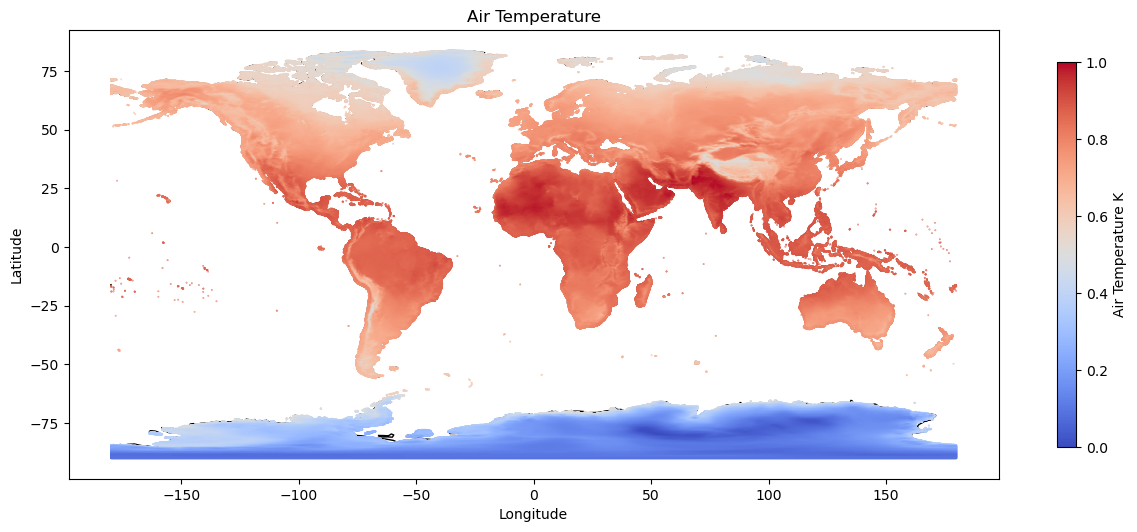

In [7]:
from ml4xcube.xr_plots import plot_slice

dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

plot_slice(
    df          = dfdn,
    var_to_plot = 'air_temperature_2m',
    xdim        = 'lon',
    ydim        = 'lat',
    color_map   = 'coolwarm',
    title       = 'Air Temperature',
    label       = 'Air Temperature K'
)

Land Surface Temperature

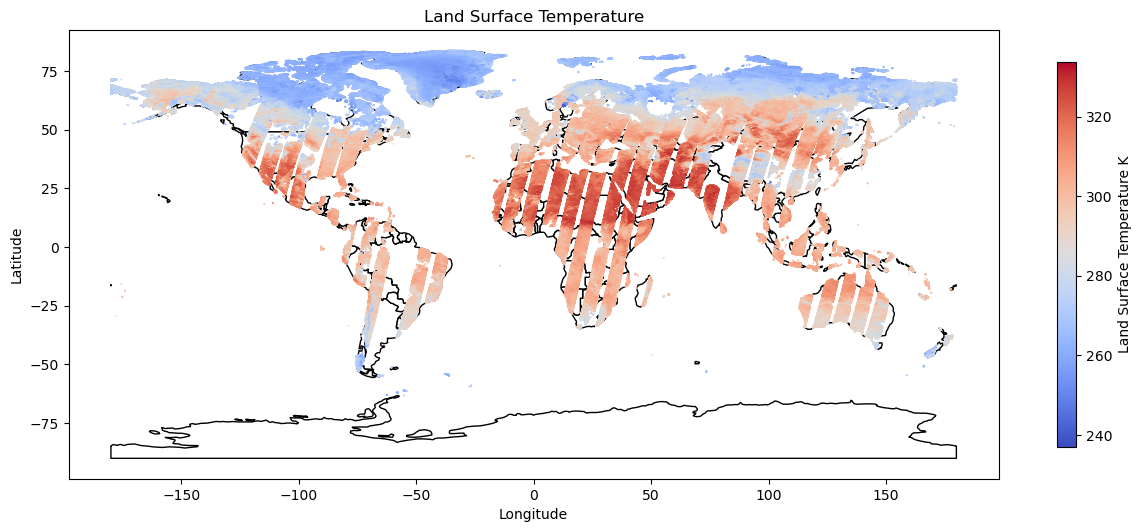

In [8]:
from ml4xcube.xr_plots import plot_slice

plot_slice(
    df          = dfdn,
    var_to_plot = 'land_surface_temperature',
    xdim        = 'lon',
    ydim        = 'lat',
    color_map   = 'coolwarm',
    title       = 'Land Surface Temperature',
    label       = 'Land Surface Temperature K'
)

### Assign train/test split
Here you can choose between random sampling and block sampling. Based on the use case, the application of ML analyses on remotely sensed data is prone to autocorrelation, especially when the data is split randomly. Block sampling is one strategy to deal with autocorrelation.

In [9]:
from ml4xcube.data_split import assign_rand_split, assign_block_split

# random sampling
xds = assign_rand_split(
    ds    = xdsm,
    split = 0.7
)

# block sampling
#xds = assign_block_split(
#    ds         = xdsm,
#    block_size = [("time", 10), ("lat", 100), ("lon", 100)],
#    split      = 0.8
#)
xds

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    split                     (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

Plot train/test assignment

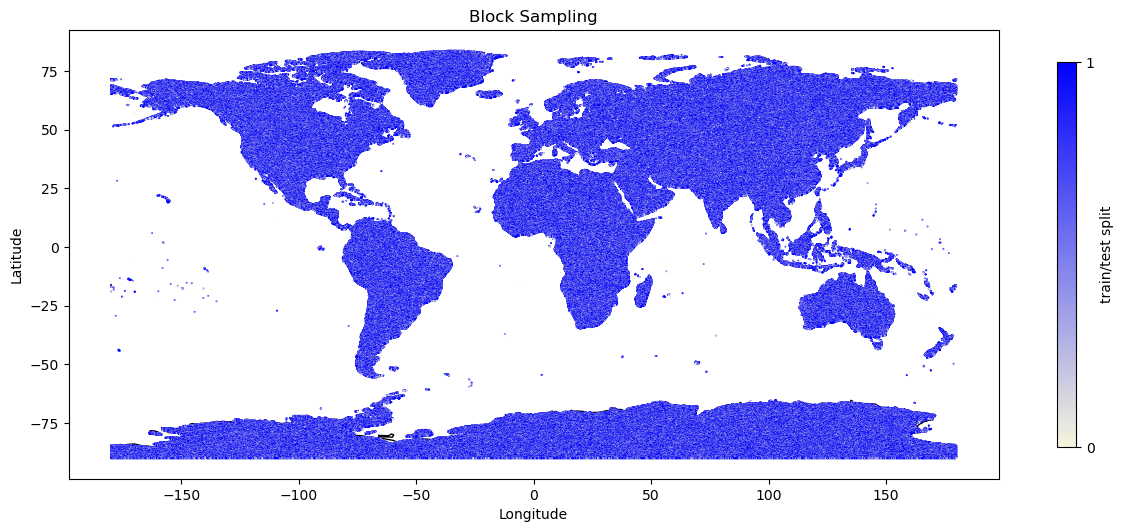

In [10]:
from ml4xcube.xr_plots import plot_slice

df = xds.sel({'time': '2002-05-21'}).to_dataframe()

dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

color_map = LinearSegmentedColormap.from_list("", ["beige","blue"])

plot_slice(
    df          = dfdn,
    var_to_plot = 'split',
    xdim        = 'lon',
    ydim        = 'lat',
    color_map   = color_map,
    title       = 'Block Sampling',
    label       = 'train/test split',
    ticks       = [0,1]
)

## Model set up

#### Initialize MLFlow experiment

In [11]:
experiment_name = "Sklearn Linear Regression of LST from AT with mlflow"
mlflow.set_experiment(experiment_name)

current_experiment=dict(mlflow.get_experiment_by_name(experiment_name))
experiment_id = current_experiment['experiment_id']

run_name = "ESDC_LR_rnd"
mlflow.sklearn.autolog()

#### Train-/ and Test Set Creation and Preprocessing

In [12]:
from ml4xcube.datasets.xr_dataset import XrDataset

dataset = XrDataset(ds=xds, num_chunks=1, rand_chunk=False).get_dataset()

{'land_surface_temperature': array([273.1604 , 273.5304 , 273.8252 , ..., 289.9852 , 289.60208,
       288.97495], dtype=float32), 'air_temperature_2m': array([271.99905, 271.99905, 271.9593 , ..., 287.65915, 287.65915,
       287.65915], dtype=float32), 'land_mask': array([ True,  True,  True, ...,  True,  True,  True]), 'split': array([ True,  True, False, ...,  True,  True,  True])}


Get range (min, max) and statistics (mean, std) of data variables for normalization or standardization.

In [13]:
from ml4xcube.preprocessing import get_range, get_statistics

at_range  = get_range(dataset, 'air_temperature_2m')
lst_range = get_range(dataset, 'land_surface_temperature')

#at_stat  = get_statistics(ds, 'air_temperature_2m')
#lst_stat = get_statistics(ds, 'land_surface_temperature')

In [14]:
from ml4xcube.preprocessing import normalize

X = normalize(dataset['air_temperature_2m'], *at_range)
y = normalize(dataset['land_surface_temperature'], *lst_range)

In [15]:
X_train, X_test = X[dataset['split'] == True], X[dataset['split'] == False]
y_train, y_test = y[dataset['split'] == True], y[dataset['split'] == False]

X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

train_data = (X_train, y_train)
test_data = (X_test, y_test)

### Train model
We iterate through the chunks of the ESDC. The data will be preprocessed by flattening, choosing values, removing NaNs, normalization or standardization. Further, we will split the data into a training and testing fraction. We generate a train data loader and a test data loader and perform a linear regression. The train and test errors are returned during model training.

In [16]:
from ml4xcube.training.sklearn import Trainer

# Define the path for saving the sklearn model
model_path = './skl_model.pth'
sgd_reg     = SGDRegressor()

with mlflow.start_run(experiment_id=experiment_id, run_name = run_name) as run:

    # Trainer instance
    trainer = Trainer(
        model          = sgd_reg,
        train_data     = train_data,
        test_data      = test_data,
        model_path     = model_path,
        mlflow_run     = mlflow,
        batch_training = False,

    )
    
    # Start training
    sgd_reg = trainer.train()

Training Score: 0.0149
Validation Score: 0.0149
Model parameters saved.


### Model Predictions

Get Air Temperature values for Lon/Lat with missing Land Surface Temperature values

In [17]:
df = xds.sel({'time' : '2002-05-21'}).to_dataframe()
df

land_surface_temperature  air_temperature_2m  \
lat        lon                                                         
 89.958333 -179.958333                       NaN          266.297180   
           -179.875000                       NaN          266.297180   
           -179.791667                       NaN          266.297180   
           -179.708333                       NaN          266.297180   
           -179.625000                       NaN          266.297180   
...                                          ...                 ...   
-89.958333  179.625000                       NaN          219.817398   
            179.708333                       NaN          219.817398   
            179.791667                       NaN          219.817398   
            179.875000                       NaN          219.817398   
            179.958333                       NaN          219.817398   

                             time  land_mask  split  
lat        lon                                       
 89.958333 -179.958333 2002-05-21      False  False  
           -179.875000 2002-05-21      False  False  
           -179.791667 2002-05-21      False   True  
           -179.708333 2002-05-21      False   True  
           -179.625000 2002-05-21      False  False  
...                           ...        ...    ...  
-89.958333  179.625000 2002-05-21       True  False  
            179.708333 2002-05-21       True   True  
            179.791667 2002-05-21       True   True  
            179.875000 2002-05-21       True   True  
            179.958333 2002-05-21       True   True  

[9331200 rows x 5 columns]

Predict missing Land Surface Temperature values from Air Temperature values

In [18]:
from ml4xcube.preprocessing import normalize
from ml4xcube.postprocessing import undo_normalizing

dfl     = df[df['land_mask'] == True]
orig    = dfl.dropna()
to_pred = dfl[np.isnan(dfl['land_surface_temperature'])]
output  = to_pred.drop('land_surface_temperature', axis = 1)

X = normalize(to_pred['air_temperature_2m'], *at_range)
X = X.values

lstp = sgd_reg.predict(X.reshape(-1, 1))
output['land_surface_temperature'] = undo_normalizing(lstp, *lst_range)
output

air_temperature_2m       time  land_mask  split  \
lat        lon                                                            
 83.208333 -73.958333           266.152954 2002-05-21       True  False   
 83.125000 -77.041667           265.867096 2002-05-21       True   True   
           -76.958333           265.832367 2002-05-21       True  False   
           -76.875000           265.832367 2002-05-21       True   True   
           -76.791667           265.832367 2002-05-21       True   True   
...                                    ...        ...        ...    ...   
-89.958333  179.625000          219.817398 2002-05-21       True  False   
            179.708333          219.817398 2002-05-21       True   True   
            179.791667          219.817398 2002-05-21       True   True   
            179.875000          219.817398 2002-05-21       True   True   
            179.958333          219.817398 2002-05-21       True   True   

                        land_surface_temperature  
lat        lon                                    
 83.208333 -73.958333                 266.637029  
 83.125000 -77.041667                 266.279321  
           -76.958333                 266.235863  
           -76.875000                 266.235863  
           -76.791667                 266.235863  
...                                          ...  
-89.958333  179.625000                208.655127  
            179.708333                208.655127  
            179.791667                208.655127  
            179.875000                208.655127  
            179.958333                208.655127  

[1739067 rows x 5 columns]

### Plot Predictions

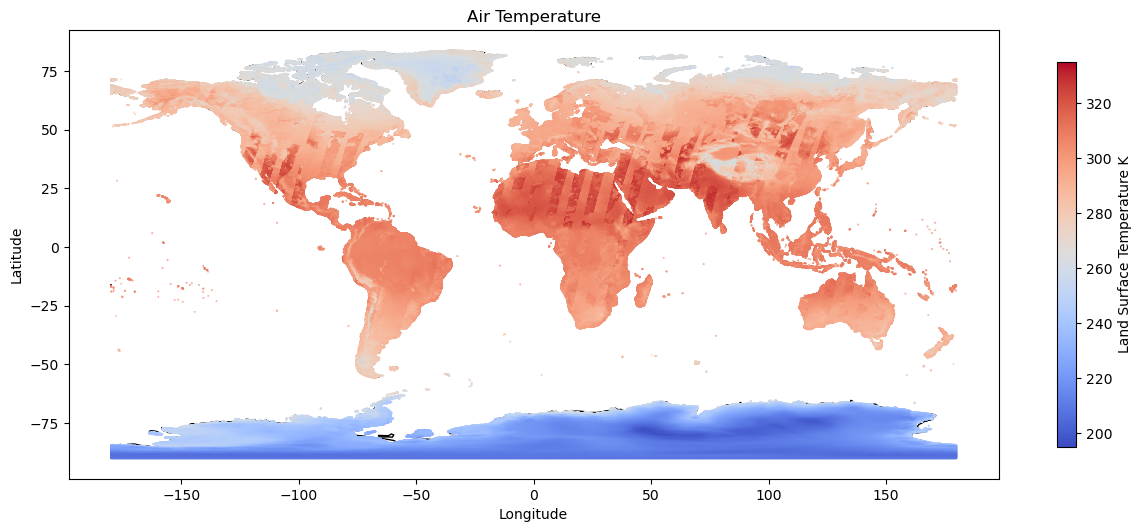

In [19]:
from ml4xcube.xr_plots import plot_slice

df  = pd.concat([orig['land_surface_temperature'], output['land_surface_temperature']])
lst = df.reset_index()

plot_slice(
    df          = lst,
    var_to_plot = 'land_surface_temperature',
    xdim        = 'lon',
    ydim        = 'lat',
    color_map   = 'coolwarm',
    title       = 'Air Temperature',
    label       = 'Land Surface Temperature K', 
    vmin        = 195,
    vmax        = 335
)